Here we derive an analytic and Monte Carlo (MC) models of the fraction of the coincident microbursts observed by both spacecraft vs. one assuming a fixed scale size.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
import scipy.special
import time
from IPython.display import Image
import pandas as pd
import time

np.random.seed(123)
# plt.style.use('Solarize_Light2')

# Load and plot the CDF data

In [2]:
cdf_path = './../data/microburst_cdf_pdf_norm_v3.csv'
cdf_data = pd.read_csv(cdf_path)

In [3]:
cdf_data.head()

,Separation [km],CDF,PDF,CDF_std,PDF_std
0,0,1.000000,0.054516,0.064798,0.015809
1,5,0.727418,0.035251,0.045269,0.011236
2,10,0.551161,0.028598,0.033266,0.008033
3,15,0.408169,0.011309,0.022510,0.005884
4,20,0.351622,0.011795,0.018943,0.004858


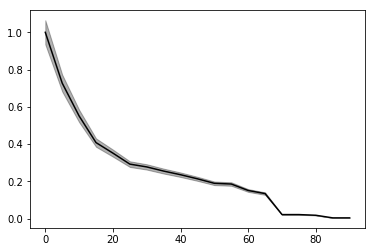

In [4]:
plt.fill_between(cdf_data['Separation [km]'], 
                 cdf_data['CDF']-cdf_data['CDF_std'], 
                 cdf_data['CDF']+cdf_data['CDF_std'], color='k', alpha=0.3);
plt.plot(cdf_data['Separation [km]'], cdf_data['CDF'], color='k');

# Develop a Monte Carlo model 
For development purposes we first assume a fixed microburst size. And generate n_bursts number of microbursts of size s and randomy scatter them on a grid of hight & width given by grid_size.

In [5]:
r = 20
grid_size = 200
n_bursts = int(1E5)
burst_size = np.random.uniform(r, r, size=n_bursts)
burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)

Visualize what the microbursts will look like on the grid.

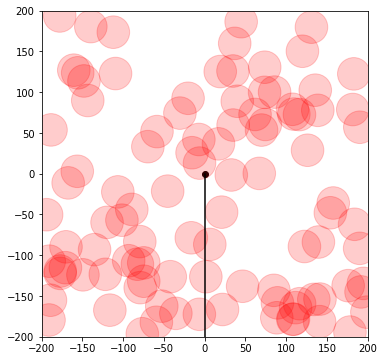

In [6]:
plot_n = 100
circles = plot_n*[None]
fig, ax = plt.subplots(figsize=(6, 6))

for c in range(plot_n):
    circles[c] = plt.Circle((burst_x[c], burst_y[c]), burst_size[c], color='r', alpha=0.2)
    ax.add_artist(circles[c])
plt.xlim(-grid_size, grid_size); plt.ylim(-grid_size, grid_size)
plt.scatter(0,0 , c='k')
plt.axvline(0, ymax=0.5, c='k')
ax.set_aspect(1.0)

Define a few helper functions to make the model look and run more smoothly

In [7]:
def dist(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [8]:
def circle_intersect(line_p, circle_p):
    """ 
    Returns true if a cicle defined by circle_p argument 
    defined as [center_x, center_y, radius] intersects a
    line defined as [x1, y1, x2, y2]. The line is assume 
    to be infinite in length. 
    
    Reference: http://mathworld.wolfram.com/Circle-LineIntersection.html
    """
    line_p[0] -= circle_p[0]; line_p[2] -= circle_p[0]
    line_p[1] -= circle_p[1]; line_p[3] -= circle_p[1]
    dx = line_p[2] - line_p[0]
    dy = line_p[3] - line_p[1]
    dr = np.sqrt(dx**2 + dy**2)
    D = line_p[0]*line_p[3] - line_p[2]*line_p[1]
    if circle_p[2]**(2)*dr**2 - D**2 >= 0:
        return True
    else:
        return False

Define the a few MC funcitons to tally the microburst events. They are mainly here to explore different tallying algorithms.

In [9]:
def mc_brute_force(r, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
    """ 
    Brute force method that is computationally slow
    but should be the closest to reality
    """
    N = np.zeros_like(bins)
    for i, bin_i in enumerate(bins):
        # Generate n_bursts number of microbursts randomly scattered in a grid
        # and fixed radius r.
        burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
        burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
        
        # Now loop over the bursts and tally up the number of microbursts 
        # observed by hypothetical spacercaft at (0, 0) and (0, bin_i).
        for bx, by in zip(burst_x, burst_y):
            if (dist(bx, by, 0, 0) <= r) and (dist(bx, by, 0, bin_i) <= r): 
                N[i] += 1
    total_N = np.sum(N)
    cdf = np.array([np.sum(N[i:])/total_N for i in range(len(bins))])
    return cdf

def cdf_simpler(r, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
    """ 
    This function tallies events that were see by both spacercaft over 
    the events seen by one, or both spacercaft as a function of spacecraft separation.
    """
    n = np.zeros(len(bins))
    
    burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    
    # Loop over the spacecraft separations.
    for i, d in enumerate(bins):
        # Loop over the microbursts.
        for bx, by in zip(burst_x, burst_y):
            # Skip if the circle did not intersect the y-axis 
            # (not going to be seen by either spacecraft).
            if not circle_intersect([0, 0, 0, 10], [bx, by, r]):
                continue
            # Both see it
            if dist(bx, by, 0, d) <= r and dist(bx, by, 0, 0) <= r: 
                n[i] += 1
    total_detected = np.sum(n)
    cdf = np.array([np.sum(n[i:])/total_detected for i in range(len(n))])
    return cdf

def mc_tally_analytic(r, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
    """ 
    This implements an MC model with an analytic tally. Benefit of this method
    is that it only has to loop through the microbursts once.
    """
    # Generate n_bursts number of microbursts randomly scattered in a grid
    # and fixed radius r.
    burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    
    N = np.zeros_like(bins)
    for bx, by in zip(burst_x, burst_y):
        # Since microburst was seen at the origin, see how far away another 
        # spacecraft would have seen it.
        if (dist(bx, by, 0, 0) <= r):
            # Since microburst was seen at the origin, find the max distance
            # it would have been observed away from the origin.
            y_max = by + np.sqrt(r**2 - bx**2)
            # All bin indicies less than y_max
            sc_idx = np.where(bins <= y_max)[0] 
            N[sc_idx] += 1
    total_N = np.sum(N)
    cdf = np.array([np.sum(N[i:])/total_N for i in range(len(bins))])
    return cdf

# Validate different MC versions against each other
to make sure we are correctly counting microbursts to compare to the data and that all of the models work as expected

In [10]:
bins = np.arange(0, 100, 5)
start_time = time.time()
cdf_brute = mc_brute_force(r, bins=bins)
print(f'MC brute force run time {round(time.time()-start_time, 2)} s')

MC brute force run time 6.79 s


In [11]:
start_time = time.time()
mc_cdf = cdf_simpler(r, bins=bins)
print(f'MC simpler run time {round(time.time()-start_time, 2)} s')

MC simpler run time 12.2 s


In [12]:
start_time = time.time()
cdf_tally_analytic = mc_tally_analytic(r, bins=bins)
print(f'MC with analytic tally run time {round(time.time()-start_time, 2)} s')

MC with analytic tally run time 0.31 s


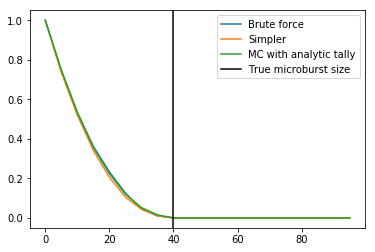

In [13]:
plt.plot(bins, cdf_brute, label='Brute force')
plt.plot(bins, mc_cdf, label='Simpler');
plt.plot(bins, cdf_tally_analytic, label='MC with analytic tally');
plt.axvline(r*2, color='k', label='True microburst size');
plt.legend();

# Analytic Microburst Scale Size Model

Here is the geometric model of the problem. The diagram below shows two spacecraft as blue cubes, separated by some distance $d$. Then for a microburst of a given radius $r$, we can show the furthest distance at which a microburst of size $r$ will be observed by both spacecraft. This case is shown with two black circles to the left and right with respect to the line that connects the two spacecraft. The center of both black circles is marked with a black dot. 

Now we find the fraction of coincident microbursts to all microbursts observed by one and not the other spacecraft.

We first look at the number of coincident microbursts. Assume that we fire N microbursts into a world with an area $A_{world}$ (that is our canvas in the following diagram). The centers of microbursts that are coincidently observed must be at most a distance $r$ from both spacecraft. Geometrically we can visualize this by tracing the center of one of the black circles as we rotate it about one of the spacecraft location. The result of this rotation are the two red circles. The red shaded area in the middle, $A_1$ is the area in which if we place a microburst center, both spacercaft will see it.

To find the number of microbursts observed by one and not the other spacecraft, consider the same picture, but now the microburst center must lie outside of $A_1$. From our earlier circle rotation we traced out the solid red curve, which coincides with the furthest that a microburst center can be and be observed by one or the other spacecraft. Thus the area of this region is $2 \pi r^2 - A_1$. 

To put it all togeather, the fraction of coincident microbursts observed by two spacecraft is given by 

$$
F = \frac{A_1}{2 \pi r^2 - A_1}
$$. The Cumulative Distribution Fuction (CDF) is the derived by assuming a distribution of microbursts e.g. a Gaussian, and calculating $F$ as a function of $d$.

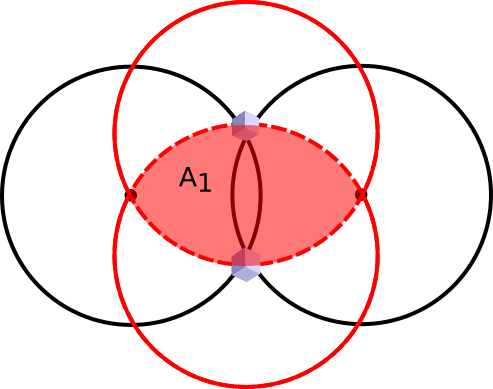

In [14]:
Image("analytic_coincident_microburst_scale_size_bounds.png")

In [15]:
A1 = lambda r, d: 2*r**2*np.arccos(d/(2*r)) - d/2*np.sqrt(4*r**2 - d**2)
F = lambda r, d: A1(r, d)/(2*np.pi*r**2 - A1(r, d))

Visualize the Analytical CDFs for a fixed-sized microburst

/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


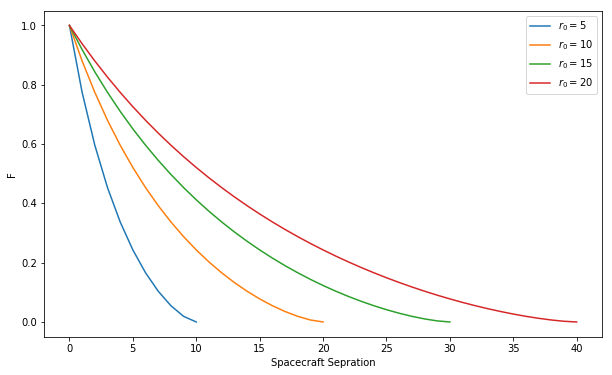

In [16]:
d = np.arange(100)
r2 = np.arange(5, 25, 5)
plt.figure(figsize=(10, 6))

for r_i in r2:
    plt.plot(d, F(r_i, d), label=r'$r_0 = $'+str(r_i));
plt.legend();
plt.xlabel('Spacecraft Sepration'); plt.ylabel('F');

# Validation of the MC vs Analytic models
Here I assume that all microbursts are the same size and check if the MC and the analytical models give the same result. I will then generalize the analytic model to make a CDF assuming some scale size PDF and not one value.

In [17]:
start_time = time.time()
cdf_analytic = F(r, bins)
print(f'Analytic MC run time {round(time.time()-start_time, 5)}')

Analytic MC run time 0.00189


/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


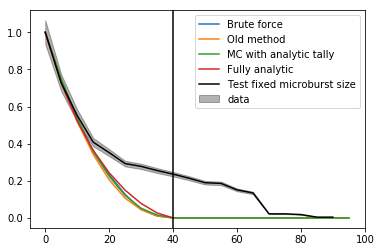

In [18]:
plt.plot(bins, cdf_brute, label='Brute force')
plt.plot(bins, mc_cdf, label='Old method');
plt.plot(bins, cdf_tally_analytic, label='MC with analytic tally');
plt.plot(bins, cdf_analytic, label='Fully analytic')
plt.plot(cdf_data['Separation [km]'], cdf_data['CDF'], c='k', label='_nolegend_')
plt.fill_between(cdf_data['Separation [km]'], 
                 cdf_data['CDF']-cdf_data['CDF_std'], 
                 cdf_data['CDF']+cdf_data['CDF_std'], 
                 color='k', alpha=0.3, label='data');
plt.axvline(r*2, color='k', label='Test fixed microburst size');
plt.legend();
plt.xlim(right=100);
#plt.savefig('compare_mc_models.png', dpi=300)

# Generalize these model to use a Maxwell microburst PDF

In [19]:
lognorm_mean=3; lognorm_sigma=1.0

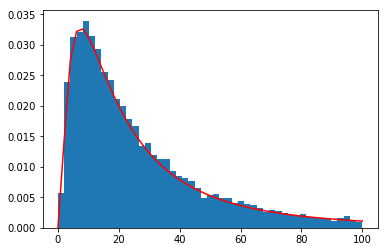

In [58]:
lognorm_rv = np.random.lognormal(mean=lognorm_mean, sigma=lognorm_sigma, size=10000)
plt.hist(lognorm_rv, bins=np.linspace(0, 100), density=True);

# Check against scipy's implementation
#help(scipy.stats.lognorm)
lognorm = scipy.stats.lognorm(scale=np.exp(lognorm_mean), s=lognorm_sigma)
plt.plot(np.linspace(0, 100), lognorm.pdf(np.linspace(0, 100)), c='r');

Specialize these MC and analytic functions to generate microbursts according to a microburst log normal PDF.

In [65]:
def mc_brute_force_lognorm(mean, sigma, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
    """ 
    Brute force method that is computationally slow
    but should be the closest to reality
    """
    N = np.zeros_like(bins)
    for i, bin_i in enumerate(bins):
        # Generate n_bursts number of microbursts randomly scattered in a grid
        # and fixed radius r.
        burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
        burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
        burst_r = np.random.lognormal(mean=mean, sigma=sigma, size=n_bursts)
        
        # Now loop over the bursts and tally up the number of microbursts 
        # observed by hypothetical spacercaft at (0, 0) and (0, bin_i).
        for bx, by, br in zip(burst_x, burst_y, burst_r):
            if (dist(bx, by, 0, 0) <= br) and (dist(bx, by, 0, bin_i) <= br): 
                N[i] += 1
    total_N = np.sum(N)
    cdf = np.array([np.sum(N[i:])/total_N for i in range(len(bins))])
    return cdf

def mc_tally_analytic_lognorm(mean, sigma, n_bursts=int(1E5), bins=np.arange(0, 100, 5)):
    """ 
    This implements an MC model with an analytic tally. Benefit of this method
    is that it only has to loop through the microbursts once.
    """
    # Generate n_bursts number of microbursts randomly scattered in a grid
    # and fixed radius r.
    burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    burst_r = np.random.lognormal(mean=mean, sigma=sigma, size=n_bursts)
    
    N = np.zeros_like(bins)
    for bx, by, br in zip(burst_x, burst_y, burst_r):
        # Since microburst was seen at the origin, see how far away another 
        # spacecraft would have seen it.
        if (dist(bx, by, 0, 0) <= br):
            # Since microburst was seen at the origin, find the max distance
            # it would have been observed away from the origin.
            y_max = by + np.sqrt(br**2 - bx**2)
            # All bin indicies less than y_max
            sc_idx = np.where(bins <= y_max)[0] 
            N[sc_idx] += 1
    total_N = np.sum(N)
    cdf = np.array([np.sum(N[i:])/total_N for i in range(len(bins))])
    return cdf


def analytic_model_dist(dist, dist_kwargs, sc_bins=np.arange(100), 
                        microburst_scales=np.arange(200)):
    """
    Assuming a distribution for the microburst scale size, 
    calculate the microburst CDF at spacecraft separations 
    given by sc_bins kwarg. The contirbutions of 
    microbursts of sizes defined by the microburst_scales
    kwarg is considered here, and is superposed and weighted
    by their relative proibability of occuring as defined
    by the scale size Gaussian PDF.
    """
    # Assuming a distribution, calculate the probability of 
    # seeing a microburst of all sizes in microburst_scales.
    microburst_cdf = dist(**dist_kwargs).cdf(microburst_scales)
    weights = microburst_cdf[1:] - microburst_cdf[:-1]
    #weights /= sum(weights)
    # CDF array is nScales x nSpacecraft shape. nScales define which 
    # microburst scales to sample the microburst PDF over and 
    # nSpacecraft size defines which spacecraft bins to evaluate the 
    # observed CDF at. 
    CDF_arr = np.nan*np.zeros((len(microburst_scales), len(sc_bins)))
    # Loop over all microburst_scales and apply the weights to each one.
    for i_scale, scale in enumerate(microburst_scales[:-1]):
        CDF_arr[i_scale, :] = weights[i_scale]*F(scale, sc_bins)
    return np.nansum(CDF_arr, axis=0)

In [66]:
# cdf_brute_lognorm = mc_brute_force_lognorm(lognorm_mean, lognorm_sigma, n_bursts=n_bursts, bins=bins)
# cdf_analytic_tally_lognorm = mc_tally_analytic_lognorm(lognorm_mean, lognorm_sigma, n_bursts=n_bursts, bins=bins)
# cale=np.exp(lognorm_mean), s=lognorm_sigma
cdf_analytic = analytic_model_dist(scipy.stats.lognorm, 
                                   {'scale':np.exp(lognorm_mean), 's':lognorm_sigma}, 
                                   sc_bins=bins)
#cdf_true = 1-(0.5+0.5*scipy.special.erf((np.log(bins) - np.exp(lognorm_mean))/(np.sqrt(2)*lognorm_sigma)))

/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arccos
  """Entry point for launching an IPython kernel.
/home/mike/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


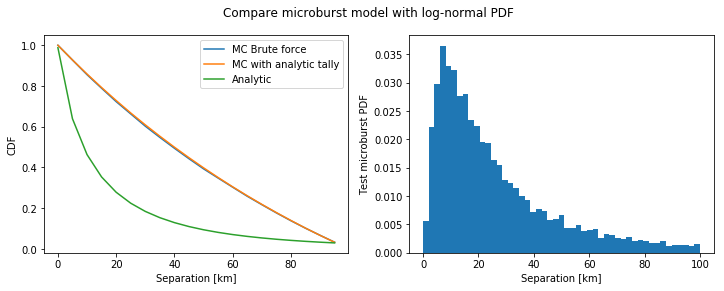

In [69]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(bins, cdf_brute_lognorm, label='MC Brute force')
ax[0].plot(bins, cdf_analytic_tally_lognorm, label='MC with analytic tally');
ax[0].plot(bins, cdf_analytic, label='Analytic')
ax[0].legend(); plt.suptitle('Compare microburst model with log-normal PDF');
ax[0].set_xlabel('Separation [km]'); ax[0].set_ylabel('CDF');

lognorm_rv = np.random.lognormal(mean=lognorm_mean, sigma=lognorm_sigma, size=10000)
H, _ = np.histogram(lognorm_rv, bins=np.linspace(0, 100), density=False)
ax[1].hist(lognorm_rv, bins=np.linspace(0, 100), density=True);
ax[1].set(xlabel='Separation [km]', ylabel='Test microburst PDF');